In [1]:
import numpy as np
import pandas as pd
import os
import cv2 
import torch
import matplotlib.pyplot as plt
from torchvision.io import read_image
from torch.utils.data import Dataset, random_split
from torch.utils.data import DataLoader
from torchvision.transforms import v2


import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

In [2]:
children = os.listdir('Dataset/D1/ds000228/derivatives/processed/Ages7-12')
infants = os.listdir('Dataset/D1/ds000228/derivatives/processed/Ages3-5')
adults = os.listdir('Dataset/D1/ds000228/derivatives/processed/Adults')

In [3]:
os.listdir('Dataset/D1/ds000228/derivatives/processed')

['.DS_Store', 'Ages7-12', 'Adults', 'Ages3-5']

In [4]:
children.remove('.DS_Store')
infants.remove('.DS_Store')
adults.remove('.DS_Store')

In [5]:
len(children)

114

In [6]:
children_images = []
infants_images = []
adults_images = []

path = 'Dataset/D1/ds000228/derivatives/processed/'

for each in children : 
    image = cv2.imread(path + 'Ages7-12/' + each)
    
    children_images.append(image)

for each in infants : 
    image = cv2.imread(path + 'Ages3-5/' + each)
    #if image != None :
    infants_images.append(image)

for each in adults : 
    image = cv2.imread(path + 'Adults/' + each)
    #if image != None :
    adults_images.append(image)

children_df = pd.DataFrame({'image' : children_images, 'label' : [1]*len(children_images)})
infants_df = pd.DataFrame({'image' : infants_images, 'label' : [0]*len(infants_images)})
adults_df = pd.DataFrame({'image' : adults_images, 'label' : [2]*len(adults_images)})

dataset_df = pd.concat([children_df, infants_df, adults_df], axis = 0)

In [7]:
transforms = v2.Compose([
    v2.RandomResizedCrop(size=(224, 224), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

class MRIImageDataset(Dataset):
    def __init__(self, dataset_df, transform=None, target_transform=None):
        self.img_labels = dataset_df['label']
        self.img_dir = dataset_df['image']
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        raw_image = self.img_dir.iloc[idx]
        #raw_image = cv2.cvtColor(raw_image, cv2.COLOR_BGR2GRAY)
        raw_image = cv2.resize(raw_image, (224, 224))
        # Add channel dimension for single channel (grayscale) image
        image = raw_image/255.0
        image = torch.from_numpy(image).permute(2, 0, 1).float() # Add channel dimension
        
        label = self.img_labels.iloc[idx]
        
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
            
        return image, label

In [8]:
dataset = MRIImageDataset(dataset_df)

In [9]:
dataset[0][0].shape

torch.Size([3, 224, 224])

In [10]:
train_dataset, val_dataset, test_dataset = random_split(dataset, [240, 30, 40])
dataset_sizes = {'train' : 240, 'test':40, 'val':30}

In [11]:
batch_size = 8
num_workers = 0
dataloaders = {
        'train': DataLoader(
            train_dataset,
            batch_size=batch_size,
            shuffle=True,
            num_workers=num_workers,
            pin_memory=torch.cuda.is_available()
        ),
        'val': DataLoader(
            val_dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=num_workers,
            pin_memory=torch.cuda.is_available()
        ),
        'test': DataLoader(
            test_dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=num_workers,
            pin_memory=torch.cuda.is_available()
        )
    }

# Test the shape
for images, labels in dataloaders['train']:
    print("Image shape:", images.shape)
    print("Labels shape:", labels.shape)
    break

Image shape: torch.Size([8, 3, 224, 224])
Labels shape: torch.Size([8])


In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [13]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    train_loss = []
    val_loss = []
    train_acc = []
    val_acc = []
    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_vgg16.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
                if phase == 'train' : 
                    train_loss.append(epoch_loss)
                    train_acc.append(epoch_acc)

                if phase == 'val' :
                    val_loss.append(epoch_loss)
                    val_acc.append(epoch_acc)

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model, train_loss, val_loss, train_acc, val_acc

In [14]:
model_ft = models.vgg16(weights='IMAGENET1K_V1')

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
#optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001
#                         , momentum=0.7)
optimizer_ft = optim.AdamW(model_ft.parameters(), lr=0.0001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5)

In [15]:
model_ft, train_loss, val_loss, train_acc, val_acc = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 2.4443 Acc: 0.3708
val Loss: 0.6848 Acc: 0.7333

Epoch 1/24
----------
train Loss: 0.7828 Acc: 0.6417
val Loss: 0.5042 Acc: 0.7667

Epoch 2/24
----------
train Loss: 0.7729 Acc: 0.6625
val Loss: 0.5424 Acc: 0.6667

Epoch 3/24
----------
train Loss: 0.4995 Acc: 0.7750
val Loss: 0.3187 Acc: 0.8000

Epoch 4/24
----------
train Loss: 0.4939 Acc: 0.7625
val Loss: 0.4399 Acc: 0.8333

Epoch 5/24
----------
train Loss: 0.2940 Acc: 0.8708
val Loss: 0.2773 Acc: 0.9000

Epoch 6/24
----------
train Loss: 0.1759 Acc: 0.9458
val Loss: 0.2460 Acc: 0.9000

Epoch 7/24
----------
train Loss: 0.1276 Acc: 0.9625
val Loss: 0.2140 Acc: 0.9333

Epoch 8/24
----------
train Loss: 0.1108 Acc: 0.9500
val Loss: 0.2192 Acc: 0.8667

Epoch 9/24
----------
train Loss: 0.0612 Acc: 0.9917
val Loss: 0.2073 Acc: 0.9333

Epoch 10/24
----------
train Loss: 0.0670 Acc: 0.9833
val Loss: 0.2062 Acc: 0.9000

Epoch 11/24
----------
train Loss: 0.0655 Acc: 0.9792
val Loss: 0.2070 Acc: 0.9000

Ep

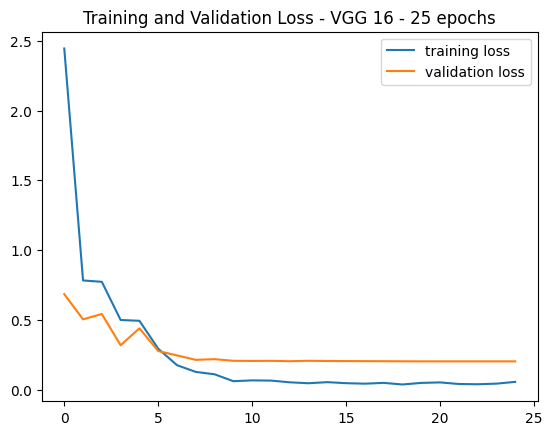

In [16]:
plt.plot(train_loss, label = 'training loss')
plt.legend()
plt.plot(val_loss, label = 'validation loss')
plt.legend()

plt.title('Training and Validation Loss - VGG 16 - 25 epochs')
plt.show()

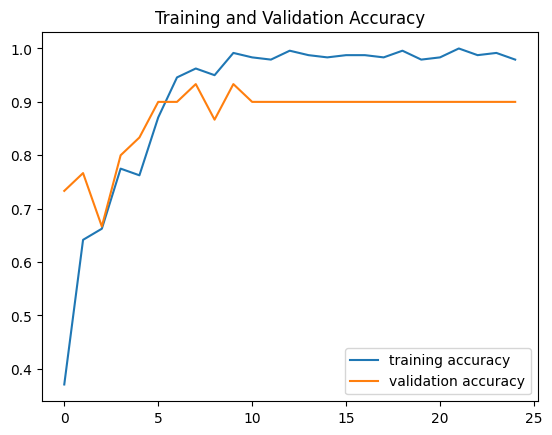

In [17]:
plt.plot(train_acc, label = 'training accuracy')
plt.legend()
plt.plot(val_acc, label = 'validation accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

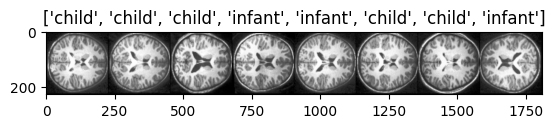

In [304]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
class_names = {
    0 : 'infant',
    1 : 'child',
    2 : 'adult'
}

imshow(out, title=[class_names[x.item()] for x in classes])

In [305]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'  label: {class_names[labels[j].item()]} predicted: {class_names[preds[j].item()]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

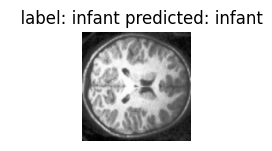

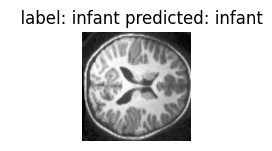

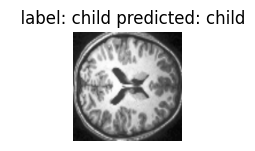

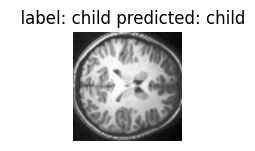

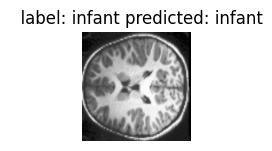

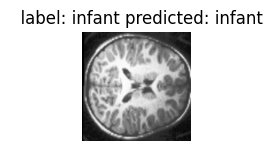

In [306]:
visualize_model(model_ft)

In [23]:
predictions = []
true_labels = []
for image, labels in iter(dataloaders['test']) : 
   
        model_ft.eval()
        outputs = model_ft(image)
        out, preds = torch.max(outputs,1)
        predictions.append(preds)
        true_labels.append(labels)

In [33]:
predictions
all_predictions = []
all_labels = []
for i in range(len(predictions)) :
    all_predictions = all_predictions + list(predictions[i])
    all_labels = all_labels + list(true_labels[i])

In [36]:
all_labels[0]-all_predictions[0]

tensor(0)

In [38]:
for i in range(len(all_predictions)) :
    all_predictions[i] = int(all_predictions[i])
    all_labels[i] = int(all_labels[i])

In [39]:
all_predictions

[0,
 1,
 0,
 0,
 1,
 2,
 2,
 0,
 1,
 0,
 1,
 2,
 0,
 1,
 0,
 1,
 0,
 0,
 2,
 0,
 1,
 0,
 0,
 0,
 0,
 2,
 1,
 0,
 2,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 2,
 1,
 0]

In [41]:
import numpy as np
from typing import Dict

def calculate_multiclass_metrics(y_true: np.ndarray, y_pred: np.ndarray) -> Dict[str, Dict[str, float]]:
    """
    Calculate precision, recall, and F1 score for each class in multiclass classification.
    
    Parameters:
    -----------
    y_true : np.ndarray
        Ground truth labels
    y_pred : np.ndarray
        Predicted labels
        
    Returns:
    --------
    Dict[str, Dict[str, float]]
        Dictionary containing metrics for each class
    """
    # Ensure inputs are numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Get unique classes
    classes = np.unique(np.concatenate([y_true, y_pred]))
    metrics = {}
    
    # Calculate metrics for each class
    for class_label in classes:
        # True Positives: Correctly predicted current class
        tp = np.sum((y_true == class_label) & (y_pred == class_label))
        
        # False Positives: Incorrectly predicted as current class
        fp = np.sum((y_true != class_label) & (y_pred == class_label))
        
        # False Negatives: Incorrectly predicted as not current class
        fn = np.sum((y_true == class_label) & (y_pred != class_label))
        
        # Calculate metrics
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        metrics[f'class_{class_label}'] = {
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'support': np.sum(y_true == class_label)  # Added support (number of samples in this class)
        }
    
    return metrics

In [42]:
calculate_multiclass_metrics(all_labels, all_predictions)

{'class_0': {'precision': np.float64(0.9523809523809523),
  'recall': np.float64(0.9523809523809523),
  'f1_score': np.float64(0.9523809523809523),
  'support': np.int64(21)},
 'class_1': {'precision': np.float64(0.9166666666666666),
  'recall': np.float64(0.9166666666666666),
  'f1_score': np.float64(0.9166666666666666),
  'support': np.int64(12)},
 'class_2': {'precision': np.float64(1.0),
  'recall': np.float64(1.0),
  'f1_score': np.float64(1.0),
  'support': np.int64(7)}}